In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math



In [3]:
# Ganti path jika file berada di lokasi berbeda
data_path = "used_cars_timeseries.csv"

df = pd.read_csv(data_path)

print("5 baris pertama:")
display(df.head())

print("\nInfo kolom:")
print(df.dtypes)

print("\nDeskripsi statistik:")
display(df.describe())


5 baris pertama:


,age,price
0,0,91580.833333
1,1,86093.429204
2,2,68011.525424
3,3,65286.374286
4,4,58277.819876



Info kolom:
age        int64
price    float64
dtype: object

Deskripsi statistik:


,age,price
count,34.000000,34.000000
mean,17.000000,34826.343531
std,11.165423,27541.784489
min,0.000000,7539.857143
25%,8.250000,15181.716537
50%,16.500000,22632.752525
75%,24.750000,47869.028158
max,50.000000,115000.000000


Jumlah titik data: 34
Umur minimum: 0.0 tahun
Umur maksimum: 50.0 tahun


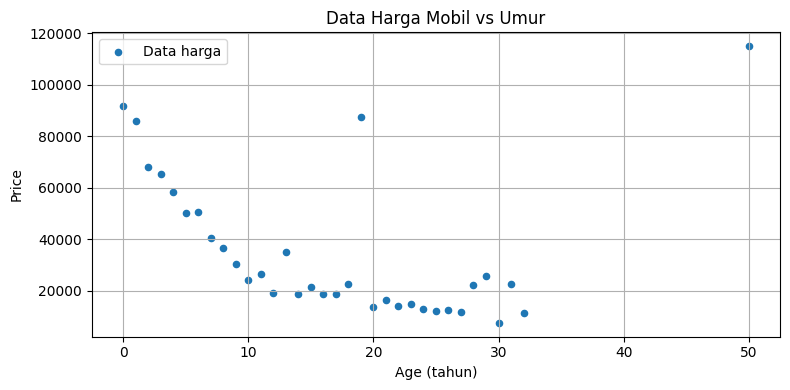

In [4]:
# Pastikan kolom nama sesuai: 'age' dan 'price'
if not {'age', 'price'}.issubset(df.columns):
    raise ValueError("Dataset harus memiliki kolom 'age' dan 'price'")

# Urutkan berdasarkan age
df = df.sort_values(by='age').reset_index(drop=True)

t_data = df['age'].astype(float).values   # waktu (t)
P_data = df['price'].astype(float).values # harga (P(t))

print("Jumlah titik data:", len(t_data))
print("Umur minimum:", t_data.min(), "tahun")
print("Umur maksimum:", t_data.max(), "tahun")

# Plot data awal untuk melihat polanya
plt.figure(figsize=(8,4))
plt.scatter(t_data, P_data, label="Data harga", s=20)
plt.xlabel("Age (tahun)")
plt.ylabel("Price")
plt.title("Data Harga Mobil vs Umur")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
def logistic_rhs(t, P, r, K):
    """
    Turunan dP/dt untuk model logistik:
        dP/dt = r * P * (1 - P/K)
    """
    return r * P * (1.0 - P / K)


def rk4_logistic(t0, P0, h, n_steps, r, K):
    """
    Solver RK4 satu dimensi untuk ODE:
        dP/dt = logistic_rhs(t, P, r, K)

    Parameter:
    - t0      : waktu awal
    - P0      : kondisi awal P(t0)
    - h       : step size
    - n_steps : jumlah langkah integrasi
    - r, K    : parameter model logistik

    Return:
    - t_values: array waktu
    - P_values: array solusi P(t)
    """
    t = t0
    P = P0
    t_values = [t]
    P_values = [P]

    for _ in range(n_steps):
        k1 = logistic_rhs(t, P, r, K)
        k2 = logistic_rhs(t + 0.5*h, P + 0.5*h*k1, r, K)
        k3 = logistic_rhs(t + 0.5*h, P + 0.5*h*k2, r, K)
        k4 = logistic_rhs(t + h,     P + h*k3,     r, K)

        P = P + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + h

        t_values.append(t)
        P_values.append(P)

    return np.array(t_values), np.array(P_values)


def rmse(a, b):
    """
    Root Mean Squared Error antara dua array a dan b.
    """
    return math.sqrt(np.mean((a - b)**2))


In [10]:
# Kita asumsikan step size h = 1 (karena age diskrit per tahun)
h = 1.0

# t_data biasanya 0, 1, 2, ..., T, tapi jumlah langkah harus mengikuti jumlah data
t0 = t_data[0]
P0 = P_data[0]

# jumlah langkah simulasi harus sama dengan jumlah data - 1
n_steps = len(t_data) - 1

print("t0 =", t0, "P0 =", P0)
print("Jumlah langkah (n_steps) =", n_steps)

def simulate_and_error(r, K):
    """
    Lakukan simulasi logistik dengan parameter r dan K,
    lalu hitung error RMSE terhadap data P_data.
    """
    t_sim, P_sim = rk4_logistic(t0, P0, h, n_steps, r, K)

    # pastikan panjang sama
    m = min(len(P_sim), len(P_data))
    P_sim = P_sim[:m]
    P_ref = P_data[:m]

    error = rmse(P_sim, P_ref)
    return error, t_sim[:m], P_sim


t0 = 0.0 P0 = 91580.83333333331
Jumlah langkah (n_steps) = 33


In [11]:
P_max = P_data.max()

# Range kasar untuk r dan K
# r negatif untuk menggambarkan penurunan (decay)
r_candidates = np.linspace(-1.0, 0.0, 21)         # dari -1.0 s/d 0.0
K_candidates = np.linspace(0.5*P_max, 2.0*P_max, 21)  # dari 0.5*Pmax s/d 2*Pmax

best_r = None
best_K = None
best_err = float("inf")

print("Mulai grid search, jumlah kombinasi:", len(r_candidates) * len(K_candidates))

for r in r_candidates:
    for K in K_candidates:
        err, _, _ = simulate_and_error(r, K)
        if err < best_err:
            best_err = err
            best_r = r
            best_K = K

print("\n=== HASIL TUNING PARAMETER LOGISTIK ===")
print("r terbaik  =", best_r)
print("K terbaik  =", best_K)
print("RMSE terbaik =", best_err)


Mulai grid search, jumlah kombinasi: 441

=== HASIL TUNING PARAMETER LOGISTIK ===
r terbaik  = -0.09999999999999998
K terbaik  = 230000.0
RMSE terbaik = 24438.034291615644


C:\Users\ZENBOOK\AppData\Local\Temp\ipykernel_21144\409679594.py:6: RuntimeWarning: overflow encountered in scalar multiply
  return r * P * (1.0 - P / K)
C:\Users\ZENBOOK\AppData\Local\Temp\ipykernel_21144\409679594.py:49: RuntimeWarning: overflow encountered in square
  return math.sqrt(np.mean((a - b)**2))


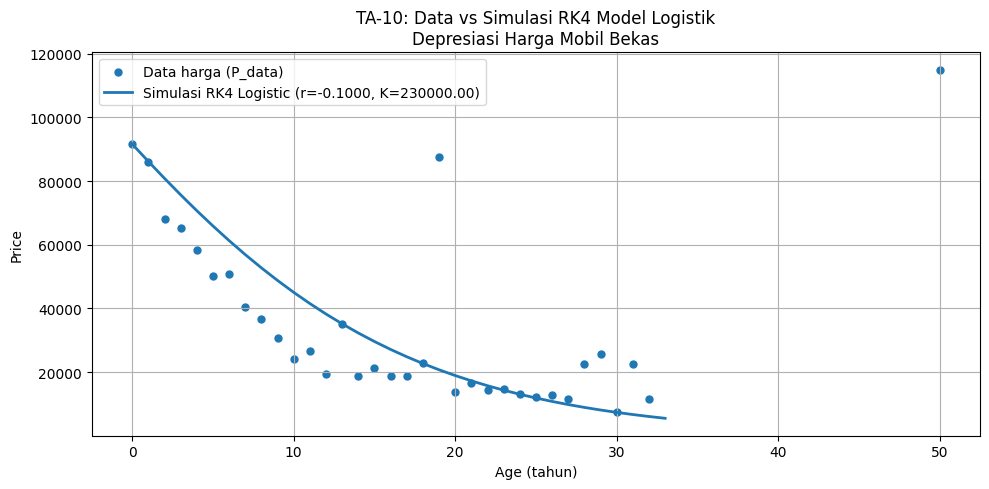

RMSE akhir (dengan r & K terbaik) = 24438.034291615644


In [12]:
# Simulasi dengan r dan K terbaik
best_error, t_sim, P_sim = simulate_and_error(best_r, best_K)

plt.figure(figsize=(10,5))
plt.scatter(t_data, P_data, label="Data harga (P_data)", s=25)
plt.plot(t_sim, P_sim, label=f"Simulasi RK4 Logistic (r={best_r:.4f}, K={best_K:.2f})", linewidth=2)

plt.xlabel("Age (tahun)")
plt.ylabel("Price")
plt.title("TA-10: Data vs Simulasi RK4 Model Logistik\nDepresiasi Harga Mobil Bekas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("RMSE akhir (dengan r & K terbaik) =", best_error)
